In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from step_shGLM_v4 import step_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
T_syn = 250
T_hist = 250
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
prop_basis_no = 2


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)
#model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/gumbelv2_sub5_s2_h2_shglm_i5000.pt"))
model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([8000])


In [5]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37000
37000


In [7]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


123


In [8]:
batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#bce_loss = nn.BCELoss(reduction="mean")

#train_zeros = torch.zeros(batch_size).cuda()
#test_zeros = 

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred, train_raw, train_spikes = model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)
    #spike_loss = torch.mean(train_spikes[:,0]**2)
    #loss = var_loss + 7*spike_loss
    loss = var_loss
    #print(i, var_loss.item(), spike_loss.item())
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred, test_raw, test_spikes = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/burst_L23_stepS_parallel_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_parallel_test_scores.npy", loss_array)


<ipython-input-8-9da9c5155836>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 67.22392339907013 0.0004484536229256708 0.0001808218061127853
[2.1937501e-01 2.2437501e-01 0.0000000e+00 2.5000001e-04 2.7250001e-01]
TEST 50 63.13714172598464 0.06121475131567733 0.04002096394693455
[0.55825    0.52725005 0.61825    0.4665     0.39237502]
TEST 100 60.18300726993661 0.10513973390511366 0.1053311976852691
[0.55450004 0.627375   0.297625   0.52825004 0.528375  ]
TEST 150 57.965430672067676 0.13811284830323967 0.10162352009558229
[0.56687504 0.56600004 0.28062502 0.552625   0.506625  ]
TEST 200 55.90098053066151 0.16880912764183242 0.11851434644630476
[0.48925003 0.65175    0.25837502 0.50012505 0.544375  ]
TEST 250 55.64386287436115 0.17263220633200138 0.14304374090942207
[0.290125   0.61350006 0.40775    0.48037502 0.502125  ]
TEST 300 52.110444719166395 0.2251705499115455 0.21774015682643022
[0.501625   0.70975006 0.414375   0.60962504 0.503125  ]
TEST 350 50.32448233162204 0.25172599884730207 0.25230160106047783
[0.40225002 0.73537505 0.41925    0.52225    0.45

TEST 3350 23.816576101864293 0.6458716737116164 0.5472634344812496
[0.41375002 0.74762505 0.595125   0.54575    0.81775004]
TEST 3400 23.978313288610092 0.6434668058068411 0.6225443044945738
[0.36187503 0.76850003 0.587      0.49950004 0.795     ]
TEST 3450 23.994281174262294 0.6432293795315054 0.7132460858630036
[0.363      0.74175006 0.62       0.49525002 0.79537505]
TEST 3500 24.957735207561793 0.6289037954183307 0.505897397469812
[0.41575003 0.750625   0.661875   0.50725    0.80825   ]
TEST 3550 23.95370860433567 0.6438326524882809 0.6001372871720534
[0.4045     0.76175004 0.60975003 0.483      0.7965    ]
TEST 3600 24.253250406535688 0.6393787697609714 0.5859051319207079
[0.40425003 0.79875004 0.5885     0.490375   0.76487505]
TEST 3650 23.765854540511665 0.6466258518948147 0.613348760845225
[0.37537503 0.79475003 0.5115     0.49462503 0.75762504]
TEST 3700 24.014028290773908 0.6429357599404385 0.48675937852876816
[0.34375003 0.72862506 0.48037502 0.46912503 0.813125  ]
TEST 3750 

TEST 6700 22.98081095426247 0.6582986536373341 0.6060202423032266
[0.48812503 0.71962506 0.415125   0.64637506 0.80275005]
TEST 6750 23.435646862173623 0.6515357050551327 0.5493392982269794
[0.365375   0.671      0.382625   0.575375   0.76900005]
TEST 6800 22.901551043340106 0.659477168099473 0.561633877740874
[0.42900002 0.68925005 0.41550002 0.64025    0.760375  ]
TEST 6850 22.76562017852499 0.6614983221571582 0.5853997728299752
[0.46350002 0.71050006 0.41412503 0.65987504 0.775125  ]
TEST 6900 23.19268223001781 0.6551483426950502 0.6237673945182105
[0.51437503 0.720875   0.44000003 0.644625   0.837625  ]
TEST 6950 22.825857338868662 0.6606026567058665 0.6849615831685476
[0.48112503 0.76575005 0.416375   0.64587504 0.77975005]
TEST 7000 23.428080497049738 0.6516482092490035 0.5391086447783453
[0.397      0.74500006 0.312875   0.569      0.75100005]
TEST 7050 22.880836897405832 0.6597851664215975 0.6062475886503764
[0.53225005 0.79787505 0.41487503 0.66387504 0.793375  ]
TEST 7100 22.

# Test 

In [4]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_parallel_i9900.pt"))
model = model.float().to("cuda")

V_ref = np.fromfile("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()
V_ref = V_ref[:48000]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")


test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final, raw, spikes = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()
raw = raw.cpu().detach().numpy()
spikes = spikes.cpu().detach().numpy()
#probs = probs.cpu().detach().numpy()

0.4456448339822404


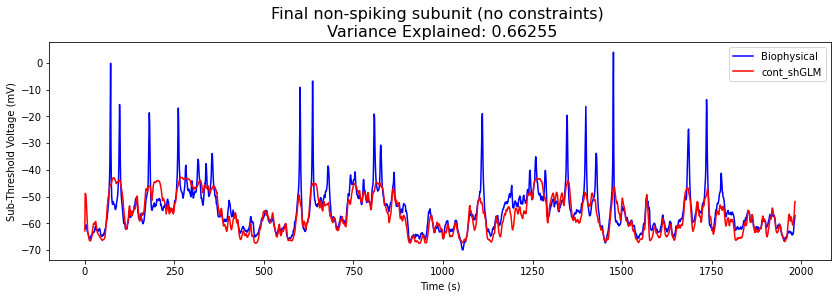

In [11]:
plt.figure(figsize = (14,4))
delay = 16

plt.plot(test_V_ref[delay:2000], label="Biophysical", c="blue")
plt.plot(test_V_final[:2000-delay]-20, label="cont_shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref[delay:],
                                                      y_pred=test_V_final[:-delay],
                                                      multioutput='uniform_average')

plt.title("Final parallel (no constraints) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/cont_shglm/final_parallel_noconstraint.png", dpi=150, bbox_inches='tight')#

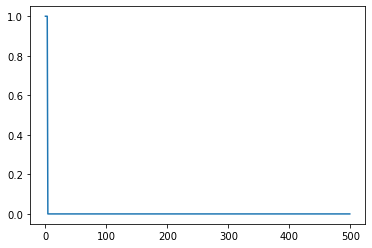

In [12]:
plt.plot(spikes[:500,0])
#print(spikes)


In [20]:
output_save = np.vstack((test_V_ref.reshape((1,-1)), test_V_final.reshape((1,-1))))
print(output_save.shape)
dend_save = raw.T
spikes_save = spikes.T
probs_save = probs.T
print(dend_save.shape)
print(spikes_save.shape)
print(probs_save.shape)

np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_V.npy", output_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_dend.npy", dend_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_spikes.npy", spikes_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_probs.npy", probs_save)

(2, 8000)
(4, 8000)
(4, 8000)
(4, 8000)


In [9]:
for name, param in model.named_parameters():
    print(name, param.data)

W_s_syn tensor([[[ 0.3636, -0.0067],
         [ 0.8123, -0.1821]],

        [[ 0.1648, -0.5033],
         [ 0.7889, -1.2196]],

        [[ 0.7365, -0.2357],
         [ 0.3847, -0.7768]],

        [[ 0.3431, -0.3001],
         [ 0.7582, -1.3856]],

        [[ 0.4279, -0.4513],
         [ 0.7921, -1.6215]]], device='cuda:0')
W_ns_syn tensor([[[-0.0576, -0.0070],
         [-0.0134, -0.4550]],

        [[ 0.3826, -0.0642],
         [ 0.5320, -0.7127]],

        [[ 0.1131,  0.0767],
         [ 0.4038, -0.6421]],

        [[ 0.1513,  0.1549],
         [ 0.3450, -0.5999]],

        [[ 0.4452, -0.1257],
         [ 0.5046, -0.7934]]], device='cuda:0')
Tau_s_syn tensor([[ 0.2074, -0.8053],
        [ 1.7283,  1.6129]], device='cuda:0')
Tau_ns_syn tensor([[-0.1851,  0.1265],
        [ 2.0884,  1.3127]], device='cuda:0')
Delta_s_syn tensor([[ 0.0329,  0.0899],
        [ 0.3123,  1.2051],
        [ 0.5550,  1.0877],
        [-0.0674,  0.3695],
        [ 0.2636,  0.8822]], device='cuda:0')
Delta_ns_s